In [1]:
import json
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# File paths
file1 = "/Users/eshasali/Desktop/CSE 258/Assignment2/renttherunway_final_data.json"

# Function to read JSON lines data from a file
def read_json_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))  # Load each JSON object per line
    return data

# Load data from each file
renttherunway_data = read_json_lines(file1)

# Display the data (printing just the first entry for readability)
print("Rent the Runway Data Sample:", renttherunway_data[0])

Rent the Runway Data Sample: {'fit': 'fit', 'user_id': '420272', 'bust size': '34d', 'item_id': '2260466', 'weight': '137lbs', 'rating': '10', 'rented for': 'vacation', 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.", 'body type': 'hourglass', 'review_summary': 'So many compliments!', 'category': 'romper', 'height': '5\' 8"', 'size': 14, 'age': '28', 'review_date': 'April 20, 2016'}


In [3]:
len(renttherunway_data)


192544

In [4]:
renttherunway_df = pd.read_json(file1, lines=True)
renttherunway_df.describe()

,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [5]:
print(f" Null values in Renttherunway dataset: \n{renttherunway_df.isnull().sum()}")

 Null values in Renttherunway dataset: 
fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64


In [6]:
# Remove rows with any null values
# columns_to_drop_nans = ['rating', 'rented for', 'height', 'age']
# cleaned_renttherunway_df = renttherunway_df.dropna(subset=columns_to_drop_nans)
cleaned_renttherunway_df = renttherunway_df.dropna()

# Display null values after cleaning to verify
cleaned_null_values = cleaned_renttherunway_df.isnull().sum()
print(f"\nNull values in Renttherunway dataset after cleaning:\n{cleaned_null_values}")

# Summary of cleaned dataset
cleaned_summary = cleaned_renttherunway_df.describe()
cleaned_summary


Null values in Renttherunway dataset after cleaning:
fit               0
user_id           0
bust size         0
item_id           0
weight            0
rating            0
rented for        0
review_text       0
body type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64


,user_id,item_id,rating,size,age
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000
mean,498991.574528,1.052277e+06,9.081985,11.437919,34.089800
std,289658.524623,8.091076e+05,1.437853,7.826784,8.113217
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,249294.000000,1.956130e+05,8.000000,4.000000,29.000000
50%,499034.000000,9.618190e+05,10.000000,9.000000,32.000000
75%,750840.000000,1.687082e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [7]:
##### Transform the nan-numerical features to the numerical label.

import re
def preprocess_data(df):
    # Convert bust size (e.g., '34D') into numerical features
    def parse_bust_size(bust):
        if isinstance(bust, str) and re.match(r'^\d+[A-Z]$', bust.upper()):  # Validate format like '34D'
            bust = bust.upper()  # Normalize to uppercase
            band, cup = int(bust[:-1]), bust[-1]
            cup_size = ord(cup) - ord('A') + 1  # A=1, B=2, C=3, ...
            return band, cup_size
        return None, None

    df['band_size'], df['cup_size'] = zip(*df['bust size'].apply(parse_bust_size))

    # Convert weight (e.g., '137lbs') to numerical
    df['weight_numeric'] = df['weight'].str.extract(r'(\d+)').astype(float)  # Extract numeric part

    # Convert height (e.g., '5\' 8"') to inches
    def height_to_inches(height):
        if isinstance(height, str) and re.match(r'^\d+\' \d+"$', height):
            height = height.replace('"', '').replace("'", "")  # Remove double quotes and apostrophe
            feet, inches = map(int, height.split())
            return feet * 12 + inches
        return None

    df['height_inches'] = df['height'].apply(height_to_inches)

    # Encode body type
    body_type_mapping = {v: i for i, v in enumerate(df['body type'].dropna().unique())}
    df['body_type_encoded'] = df['body type'].map(body_type_mapping)

    # Encode rented for
    rented_for_mapping = {v: i for i, v in enumerate(df['rented for'].dropna().unique())}
    df['rented_for_encoded'] = df['rented for'].map(rented_for_mapping)

    # Drop or fill missing values
    df = df.dropna(subset=['band_size', 'cup_size', 'weight_numeric', 'height_inches', 
                           'body_type_encoded', 'rented_for_encoded', 'fit'])

    return df

# Apply preprocessing to the dataset
cleaned_df = preprocess_data(cleaned_renttherunway_df)

# Check the updated dataset
print(cleaned_df.head())


   fit  user_id bust size  item_id  weight  rating     rented for  \
0  fit   420272       34d  2260466  137lbs    10.0       vacation   
1  fit   273551       34b   153475  132lbs    10.0          other   
3  fit   909926       34c   126335  135lbs     8.0  formal affair   
4  fit   151944       34b   616682  145lbs    10.0        wedding   
5  fit   734848       32b   364092  138lbs     8.0           date   

                                         review_text          body type  \
0  An adorable romper! Belt and zipper were a lit...          hourglass   
1  I rented this dress for a photo shoot. The the...  straight & narrow   
3  I rented this for my company's black tie award...               pear   
4  I have always been petite in my upper body and...           athletic   
5  Didn't actually wear it. It fit perfectly. The...           athletic   

                                     review_summary  ... height size   age  \
0                              So many compliments!  ...

In [8]:
def get_value_counts_for_all_columns(dataset, columns):
    for column in columns:
        if column:
            print(f"--- Value Counts for Column: {column} ---")
            print(dataset[column].value_counts())
            print("\n")

get_value_counts_for_all_columns(cleaned_df, columns = ['weight', 'height', 'size', 'age', 'bust size', 'body type'])

--- Value Counts for Column: weight ---
weight
130lbs    12231
135lbs    11395
125lbs    11111
140lbs    10113
120lbs     9180
          ...  
239lbs        1
221lbs        1
87lbs         1
70lbs         1
233lbs        1
Name: count, Length: 181, dtype: int64


--- Value Counts for Column: height ---
height
5' 4"     20075
5' 6"     17724
5' 7"     17038
5' 5"     16889
5' 3"     14961
5' 2"     12200
5' 8"     11530
5' 9"      7738
5' 1"      5228
5' 10"     4887
5' 0"      2884
5' 11"     2077
6' 0"       938
4' 11"      718
6' 1"       253
4' 10"      152
6' 2"        89
4' 9"        48
6' 3"        23
6' 4"        14
4' 6"        11
4' 8"        10
4' 7"        10
6' 6"         1
Name: count, dtype: int64


--- Value Counts for Column: size ---
size
8     31011
4     23419
12    17805
16    11811
20    11248
1     10893
14     8247
24     5225
9      1989
13     1883
28     1762
17     1413
5      1368
21     1042
25      692
2       588
32      558
3       556
39      498
7     

In [9]:
def compute_statistics(data, dataset_name):

    # Basic stats
    num_transactions = len(data)
    num_customers = data['user_id'].nunique()
    num_products = data['item_id'].nunique()

    # Additional stats
    avg_transactions_per_customer = num_transactions / num_customers
    avg_transactions_per_product = num_transactions / num_products
    median_transactions_per_customer = data.groupby('user_id').size().median()
    median_transactions_per_product = data.groupby('item_id').size().median()
    
    # Fit feedback ratios
    fit_feedback_ratios = data['fit'].value_counts(normalize=True).to_dict()
    fraction_fit = fit_feedback_ratios.get('fit', 0.0)
    fraction_small = fit_feedback_ratios.get('small', 0.0)
    fraction_large = fit_feedback_ratios.get('large', 0.0)

    # Active users/products (more than 5 transactions)
    active_users = (data.groupby('user_id').size() > 5).sum()
    active_products = (data.groupby('item_id').size() > 5).sum()

    # Unique users per product
    avg_unique_users_per_product = data.groupby('item_id')['user_id'].nunique().mean()

    # Compile enhanced stats
    stats = {
        'Number of Transactions': num_transactions,
        'Numober of Customers (Unique)': num_customers,
        'Number of Products (Unique)': num_products,
        'Avg Transactions per Customer': avg_transactions_per_customer,
        'Avg Transactions per Product': avg_transactions_per_product,
        'Median Transactions per Customer': median_transactions_per_customer,
        'Median Transactions per Product': median_transactions_per_product,
        'Fraction Fit': fraction_fit,
        'Fraction Small': fraction_small,
        'Fraction Large': fraction_large,
        'Number of Active Customers (>5 Transactions)': active_users,
        'Number of Active Products (>5 Transactions)': active_products,
        'Avg Unique Users per Product': avg_unique_users_per_product
    }
    return stats

renttherunway_stats = compute_statistics(cleaned_df, "RentTheRunWay")


stats_table = pd.DataFrame({
    "RenttheRunway": renttherunway_stats 
})
print(stats_table)

                                              RenttheRunway
Number of Transactions                        135498.000000
Numober of Customers (Unique)                  71379.000000
Number of Products (Unique)                     5668.000000
Avg Transactions per Customer                      1.898289
Avg Transactions per Product                      23.905787
Median Transactions per Customer                   1.000000
Median Transactions per Product                   10.000000
Fraction Fit                                       0.736158
Fraction Small                                     0.133389
Fraction Large                                     0.130452
Number of Active Customers (>5 Transactions)    3005.000000
Number of Active Products (>5 Transactions)     3781.000000
Avg Unique Users per Product                      23.873853


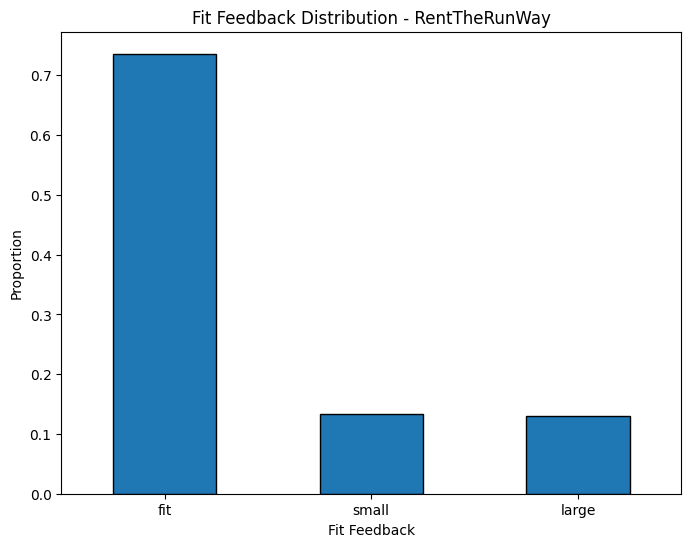

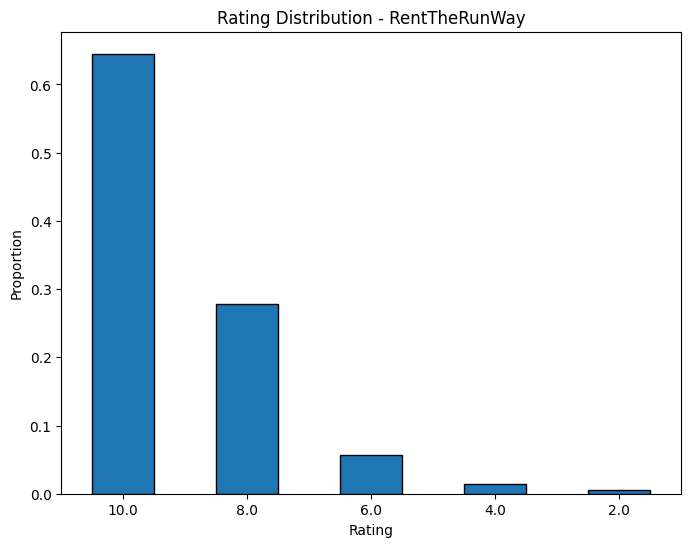

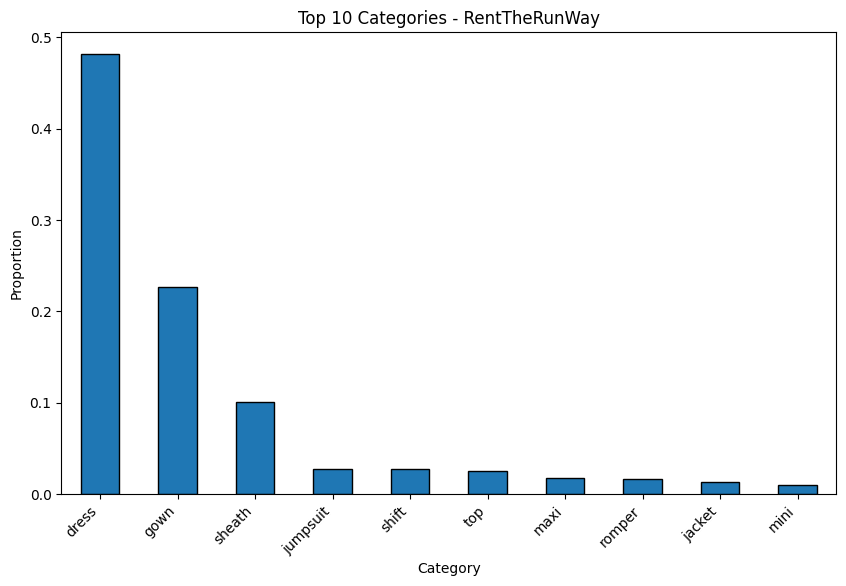

In [10]:
import matplotlib.pyplot as plt

def plot_distributions(dataset, dataset_name):

    if 'fit' in dataset.columns:
        fit_distribution = dataset['fit'].value_counts(normalize=True)
        plt.figure(figsize=(8, 6))
        fit_distribution.plot(kind='bar', edgecolor='black')
        plt.title(f"Fit Feedback Distribution - {dataset_name}")
        plt.xlabel("Fit Feedback")
        plt.ylabel("Proportion")
        plt.xticks(rotation=0)
        plt.show()
    
    if 'rating' in dataset.columns:
        rating_distribution = dataset['rating'].value_counts(normalize=True)
        plt.figure(figsize=(8, 6))
        rating_distribution.plot(kind='bar', edgecolor='black')
        plt.title(f"Rating Distribution - {dataset_name}")
        plt.xlabel("Rating")
        plt.ylabel("Proportion")
        plt.xticks(rotation=0)
        plt.show()
    
    if 'category' in dataset.columns:
        category_distribution = dataset['category'].value_counts(normalize=True).head(10)
        plt.figure(figsize=(10, 6))
        category_distribution.plot(kind='bar', edgecolor='black')
        plt.title(f"Top 10 Categories - {dataset_name}")
        plt.xlabel("Category")
        plt.ylabel("Proportion")
        plt.xticks(rotation=45, ha='right')
        plt.show()

plot_distributions(cleaned_df, "RentTheRunWay")

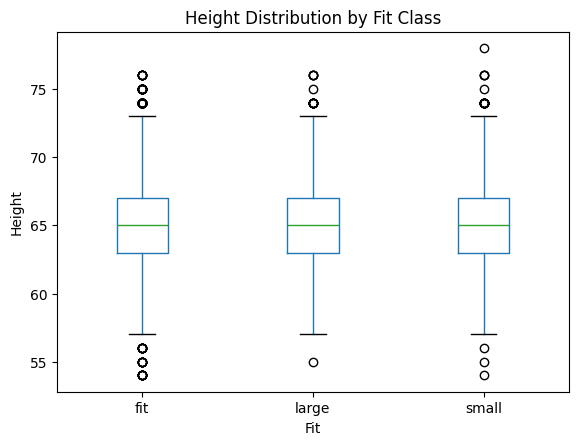

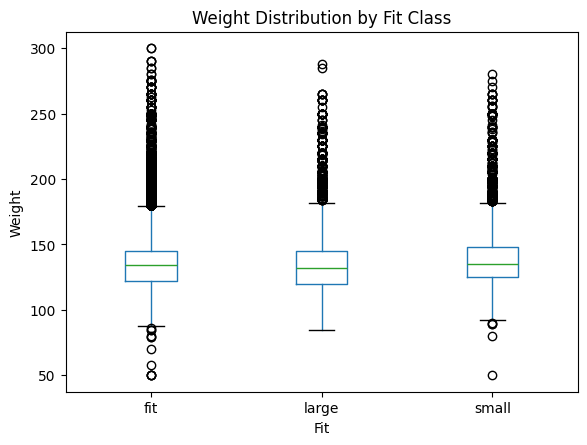

In [11]:
# Box plot of height grouped by fit
cleaned_df.boxplot(column='height_inches', by='fit', grid=False)
plt.title('Height Distribution by Fit Class')
plt.suptitle('')
plt.xlabel('Fit')
plt.ylabel('Height')
plt.show()

# Box plot of weight grouped by fit
cleaned_df.boxplot(column='weight_numeric', by='fit', grid=False)
plt.title('Weight Distribution by Fit Class')
plt.suptitle('')
plt.xlabel('Fit')
plt.ylabel('Weight')
plt.show()


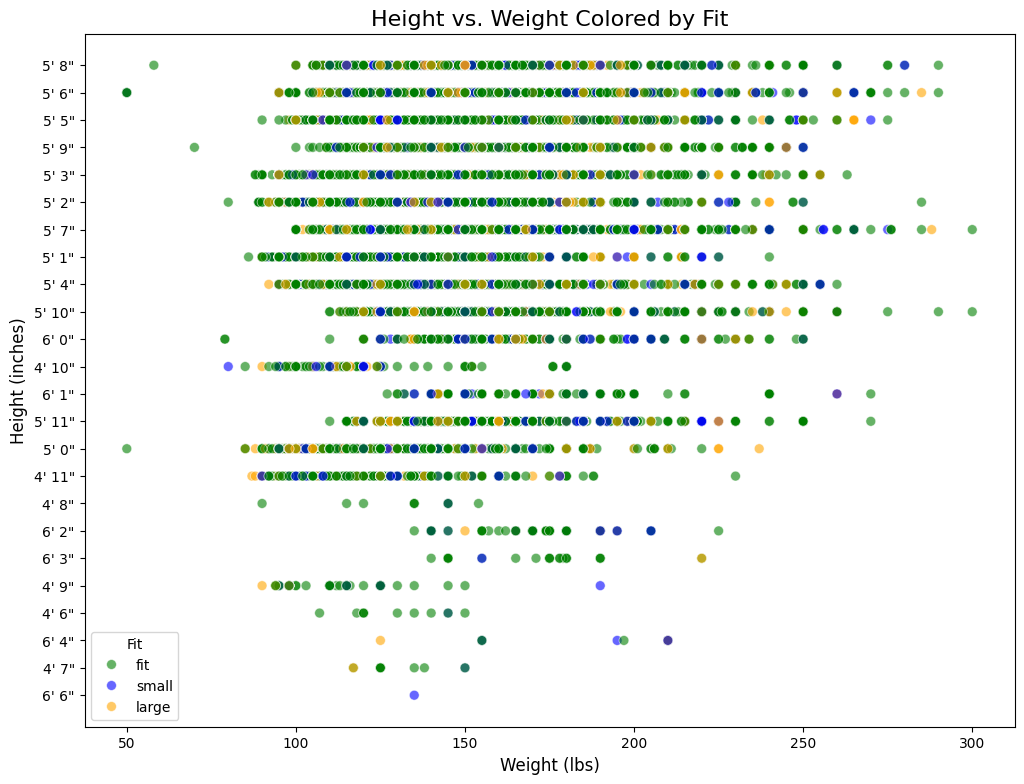

In [12]:
plt.figure(figsize=(12, 9))  
sns.scatterplot(data=cleaned_df, x='weight_numeric', y='height', hue='fit', alpha=0.6, s=50, palette={'fit': 'green', 'small': 'blue', 'large': 'orange'})
plt.title('Height vs. Weight Colored by Fit', fontsize=16)  
plt.xlabel('Weight (lbs)', fontsize=12)  
plt.ylabel('Height (inches)', fontsize=12)  
plt.legend(title='Fit', fontsize=10)
plt.show()


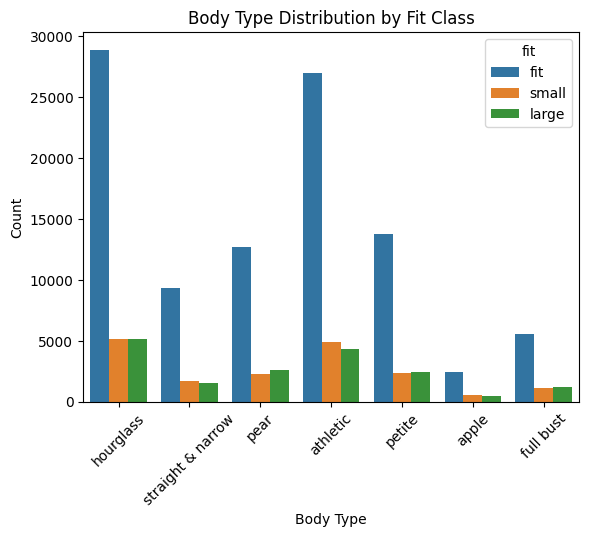

In [13]:
# Bar plot of body type vs fit
sns.countplot(data=cleaned_df, x='body type', hue='fit')
plt.title('Body Type Distribution by Fit Class')
plt.xlabel('Body Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


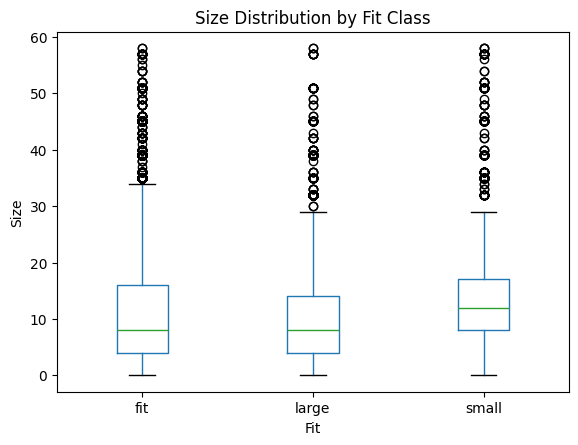

In [14]:
# Box plot of size grouped by fit
cleaned_df.boxplot(column='size', by='fit', grid=False)
plt.title('Size Distribution by Fit Class')
plt.suptitle('')
plt.xlabel('Fit')
plt.ylabel('Size')
plt.show()
    

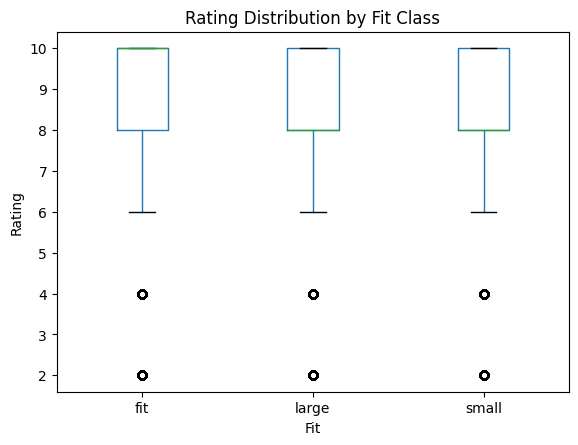

In [15]:
# Box plot of rating grouped by fit
cleaned_df.boxplot(column='rating', by='fit', grid=False)
plt.title('Rating Distribution by Fit Class')
plt.suptitle('')
plt.xlabel('Fit')
plt.ylabel('Rating')
plt.show()


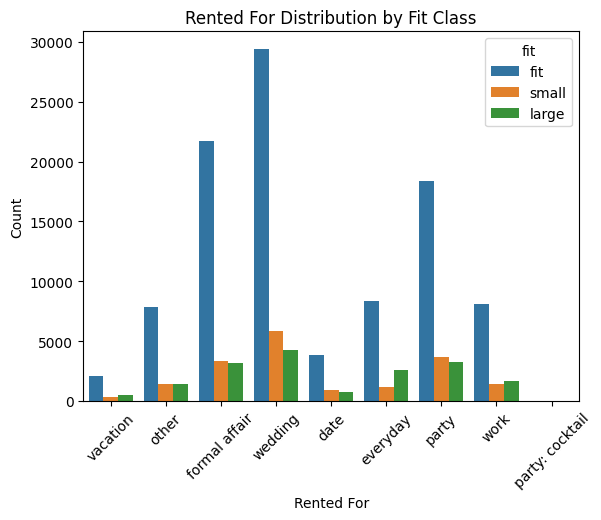

In [16]:
# Bar plot of rented for vs fit - might not be needed
sns.countplot(data=cleaned_df, x='rented for', hue='fit')
plt.title('Rented For Distribution by Fit Class')
plt.xlabel('Rented For')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


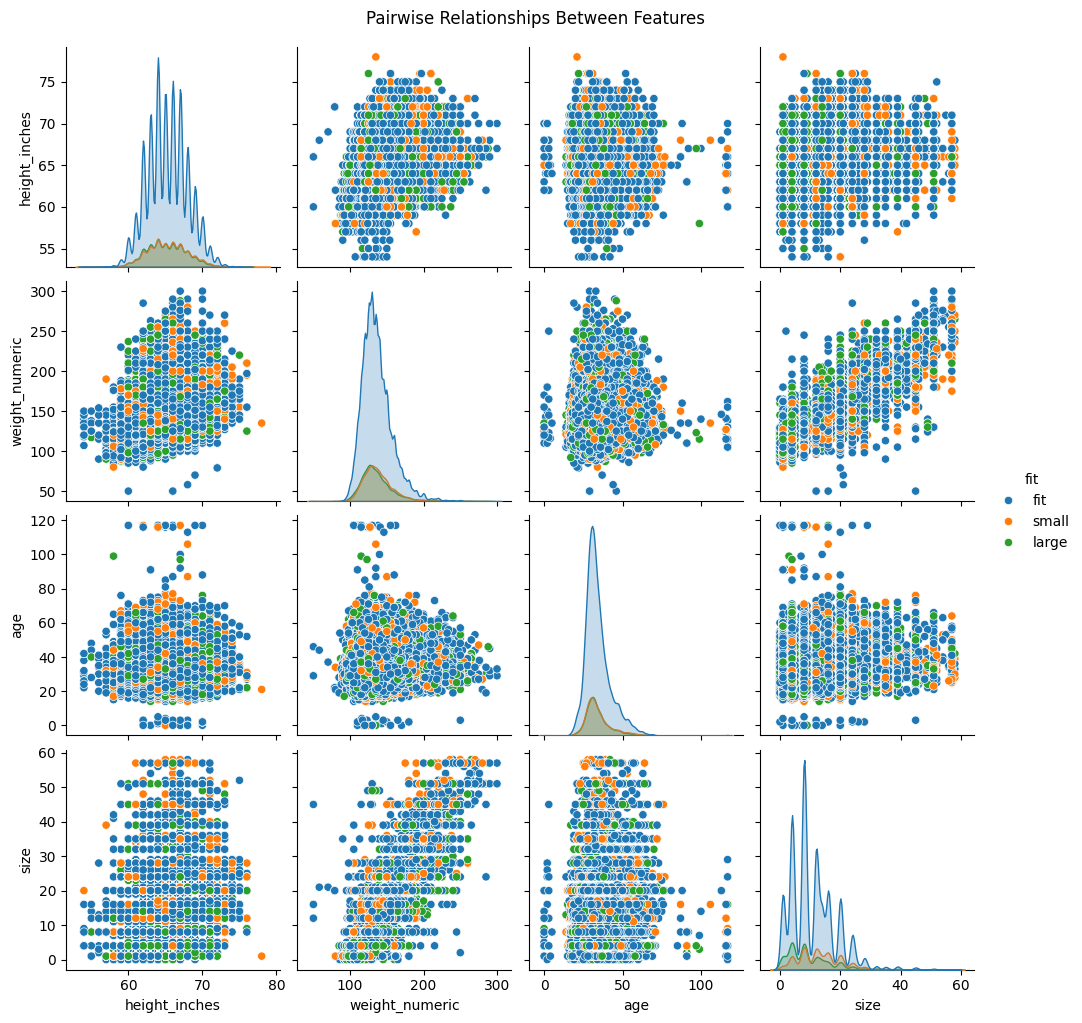

In [17]:
# Pair plot for key features with fit as hue
sns.pairplot(data=cleaned_df, vars=['height_inches', 'weight_numeric', 'age', 'size'], hue='fit', diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Features', y=1.02)
plt.show()


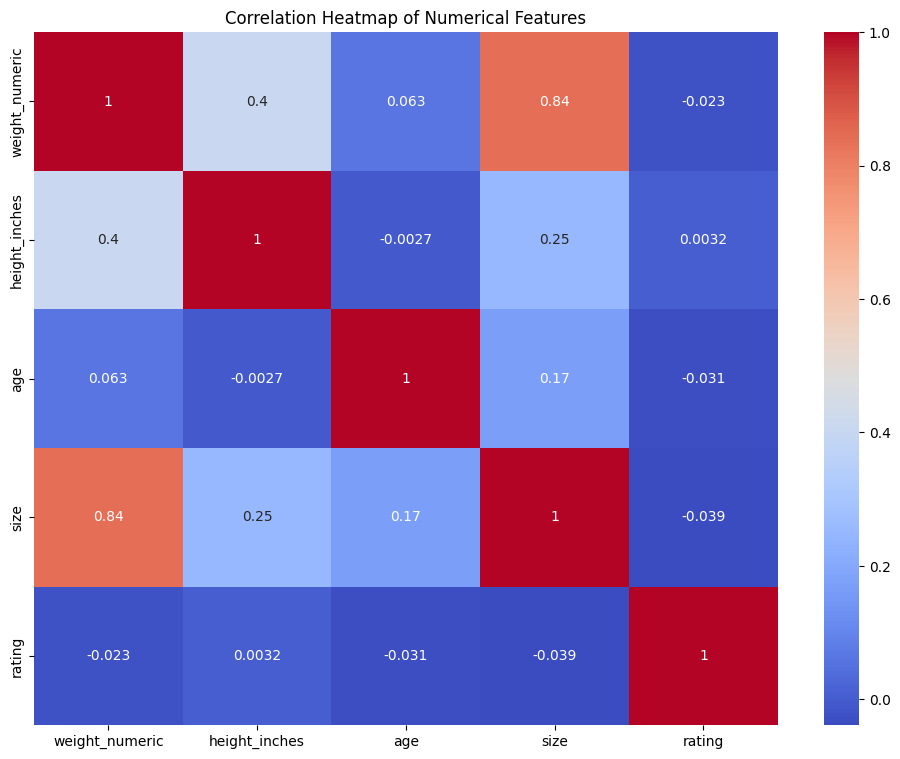

In [18]:
# Compute correlation matrix
correlation_matrix = cleaned_df[['weight_numeric', 'height_inches', 'age', 'size', 'rating']].corr()

# Heatmap
plt.figure(figsize=(12, 9))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eshasali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


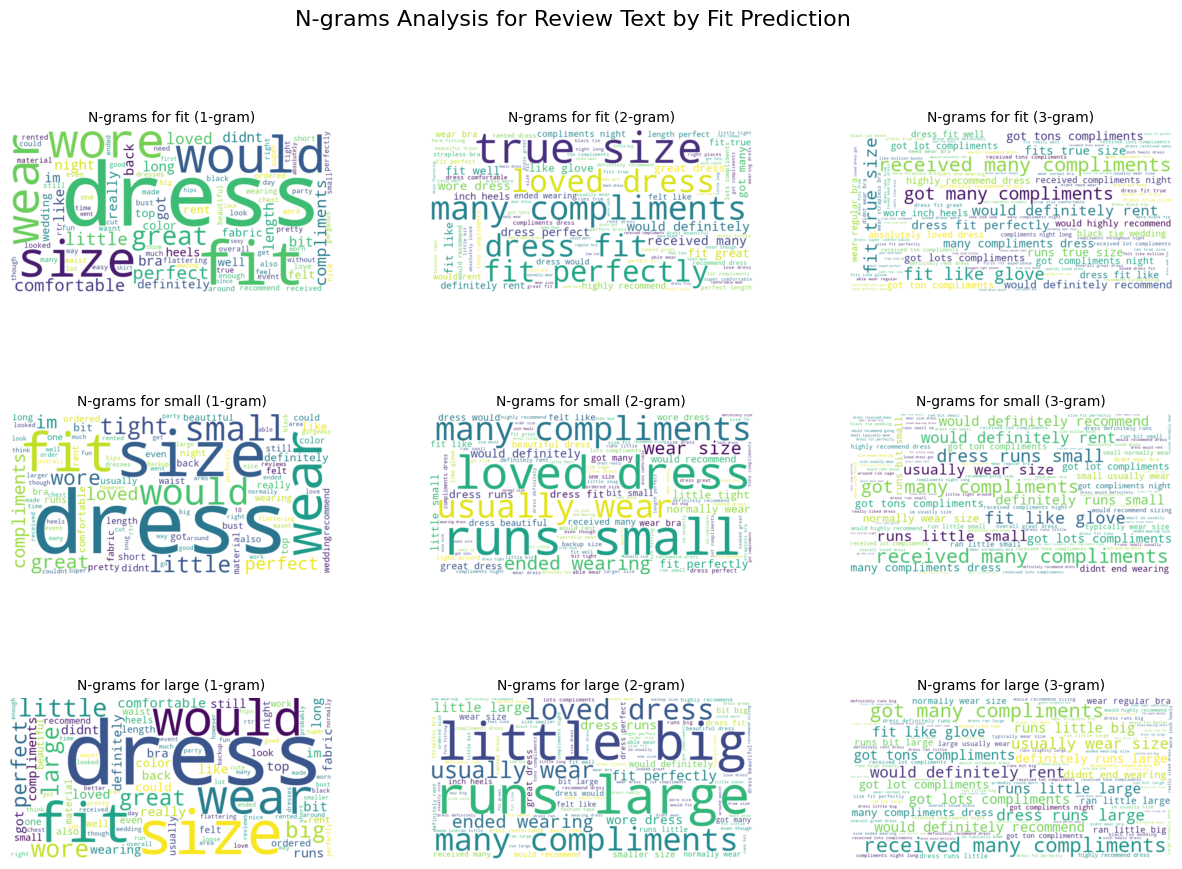

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import string

nltk.download('stopwords')

reviews_df = cleaned_df.copy()

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation]) 
    text = ' '.join([word for word in text.split() if word not in stop_words])  
    return text

reviews_df['cleaned_text'] = reviews_df['review_text'].apply(preprocess_text)

def generate_wordclouds(df, ngram_ranges, fit_values, title_prefix):
    fig, axes = plt.subplots(len(fit_values), len(ngram_ranges), figsize=(15, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, fit_value in enumerate(fit_values):
        subset = df[df['fit'] == fit_value]
        
        for j, ngram_range in enumerate(ngram_ranges):
            vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=100)
            ngram_counts = vectorizer.fit_transform(subset['cleaned_text'])
            ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_counts.sum(axis=0).A1))
            
            ax = axes[i, j] if len(fit_values) > 1 else axes[j]
            wc = WordCloud(background_color='white', colormap='viridis', width=800, height=400)
            wc.generate_from_frequencies(ngram_freq)
            ax.imshow(wc, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f'{title_prefix} for {fit_value} ({ngram_range[0]}-gram)', fontsize=10)

    plt.suptitle('N-grams Analysis for Review Text by Fit Prediction', fontsize=16)
    plt.show()

fit_values = ['fit', 'small', 'large']
ngram_ranges = [(1, 1), (2, 2), (3, 3)]  

generate_wordclouds(reviews_df, ngram_ranges, fit_values, title_prefix='N-grams')